Multi Scale as input to the transformer

Using device: cuda


/tmp/ipython-input-4229505686.py:50: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)


Data split: Train: 2128, Validation: 237, Test: 263

Model Architecture:
MultiScaleTransformer(
  (input_embedding): Linear(in_features=4, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((64,), eps

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.043624 | Val Loss: 0.000892
Epoch 2/100 | Train Loss: 0.005686 | Val Loss: 0.002326
Epoch 3/100 | Train Loss: 0.003387 | Val Loss: 0.001582
Epoch 4/100 | Train Loss: 0.003073 | Val Loss: 0.002315
Epoch 5/100 | Train Loss: 0.002433 | Val Loss: 0.002487
Epoch 6/100 | Train Loss: 0.002208 | Val Loss: 0.001258
Epoch 7/100 | Train Loss: 0.001828 | Val Loss: 0.001322
Epoch 8/100 | Train Loss: 0.001641 | Val Loss: 0.000480
Epoch 9/100 | Train Loss: 0.001493 | Val Loss: 0.000602
Epoch 10/100 | Train Loss: 0.001544 | Val Loss: 0.000351
Epoch 11/100 | Train Loss: 0.001406 | Val Loss: 0.000369
Epoch 12/100 | Train Loss: 0.001280 | Val Loss: 0.000325
Epoch 13/100 | Train Loss: 0.001267 | Val Loss: 0.000311
Epoch 14/100 | Train Loss: 0.001248 | Val Loss: 0.000441
Epoch 15/100 | Train Loss: 0.001180 | Val Loss: 0.000358
Epoch 16/100 | Train Loss: 0.001222 | Val Loss: 0.000347
Epoch 17/100 | Train Loss: 0.001116 | Val Loss: 0.000741
Epoch 18/100 | Train Loss: 0.001218 | Va

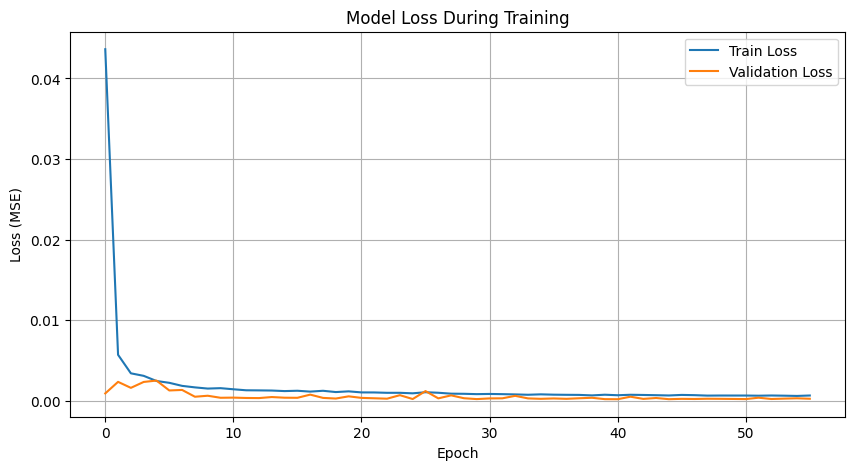

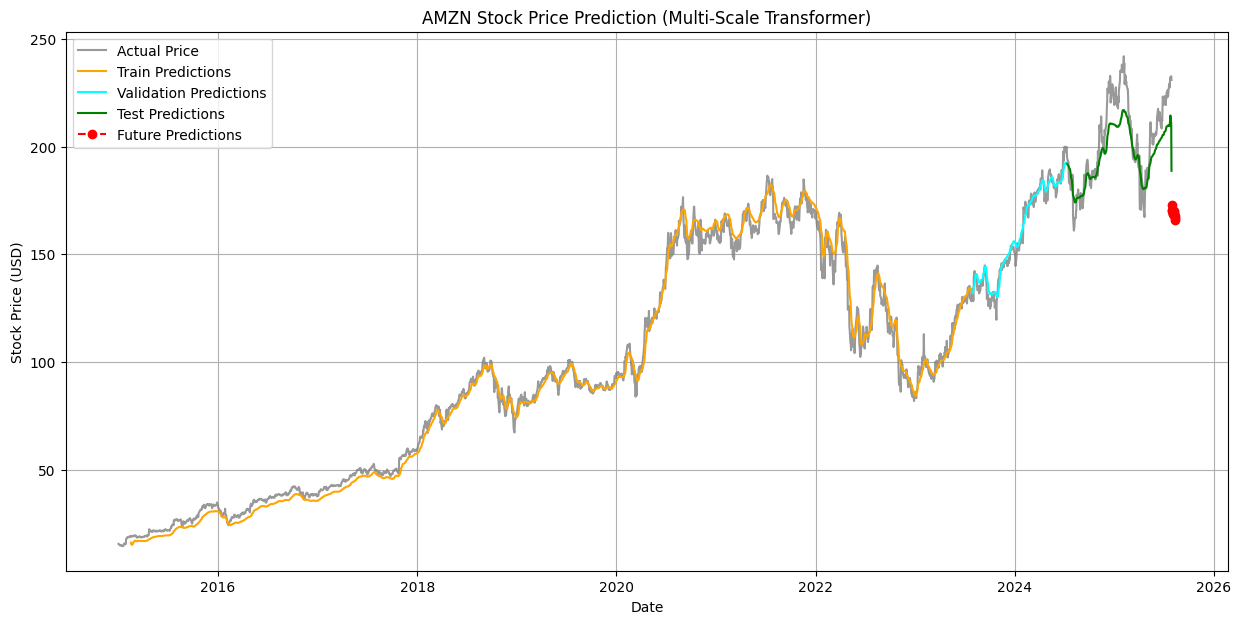

Cleaned up model file: best_transformer_predictor.pth


In [ ]:
import yfinance as yf
import numpy as np
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math
import os

# Configuration
def get_config():
    """Returns a dictionary of configuration parameters."""
    return {
        # Data and Preprocessing
        "ticker": "AMZN",
        "start_date": "2015-01-01",
        "end_date": (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d'),
        "test_size": 0.1,
        "validation_size": 0.1,
        "look_back": 30,
        "wavelet": "db4",
        "wavelet_level": 3,
        # Transformer Model Hyperparameters
        "d_model": 64,  # Embedding dimension
        "nhead": 4,  # Number of attention heads
        "num_encoder_layers": 3,
        "dim_feedforward": 256,
        "model_dropout": 0.1,
        # Training
        "epochs": 100,
        "batch_size": 64,
        "learning_rate": 0.0005,
        "patience": 15,
        "future_days_to_predict": 14,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "model_save_path": "best_transformer_predictor.pth",
        "gradient_clip": 1.0,
    }

# Data Handling
def download_stock_data(ticker, start, end):
    """Downloads stock data from Yahoo Finance."""
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        if df.empty:
            raise ValueError(f"No data retrieved for ticker {ticker}")
        close_prices = df['Close'].values.reshape(-1, 1)
        dates = df.index
        return close_prices, dates, df
    except Exception as e:
        raise RuntimeError(f"Error downloading data: {e}")

def decompose_wavelet(data, wavelet='db4', level=3):
    """Performs wavelet decomposition."""
    max_level = pywt.dwt_max_level(len(data), wavelet)
    level = min(level, max_level)
    if level <= 0:
        raise ValueError("Wavelet decomposition level must be positive and feasible")
    coeffs = pywt.wavedec(data.flatten(), wavelet, level=level, mode='per')
    return coeffs

def upsample_coeff(coeff, coeffs, wavelet, index, target_len):
    """Upsamples a single wavelet coefficient to original length."""
    coeffs_up = [np.zeros_like(c) for c in coeffs]
    coeffs_up[index] = coeff
    reconstructed = pywt.waverec(coeffs_up, wavelet, mode='per')
    if len(reconstructed) > target_len:
        return reconstructed[:target_len]
    elif len(reconstructed) < target_len:
        return np.pad(reconstructed, (0, target_len - len(reconstructed)), 'edge')
    return reconstructed

def create_sequences(data, look_back):
    """Creates input/output sequences for single-day prediction."""
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])  # Shape: (look_back, num_components)
        y.append(data[i + look_back, 0])  # Next day's approximation component
    return np.array(X), np.array(y)

# Transformer Model
class PositionalEncoding(nn.Module):
    """Injects positional information into input embeddings."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class MultiScaleTransformer(nn.Module):
    """Transformer model for multi-scale wavelet inputs."""
    def __init__(self, config):
        super(MultiScaleTransformer, self).__init__()
        self.d_model = config["d_model"]
        self.input_embedding = nn.Linear(config["wavelet_level"] + 1, self.d_model)
        self.pos_encoder = PositionalEncoding(self.d_model, config["model_dropout"])
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=config["nhead"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["model_dropout"],
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=config["num_encoder_layers"])
        self.layer_norm = nn.LayerNorm(self.d_model)
        self.output_layer = nn.Linear(self.d_model, 1)

    def forward(self, src):
        # src: (batch_size, look_back, num_components)
        src = self.input_embedding(src) * math.sqrt(self.d_model)  # (batch_size, look_back, d_model)
        src = self.pos_encoder(src)  # (batch_size, look_back, d_model)
        output = self.transformer_encoder(src)  # (batch_size, look_back, d_model)
        output = self.layer_norm(output[:, -1, :])  # (batch_size, d_model)
        output = self.output_layer(output)  # (batch_size, 1)
        return output

# Training and Evaluation
def train_model(model, config, train_loader, val_loader, scaler):
    """Trains the model with early stopping."""
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
    min_val_loss = float('inf')
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(config["epochs"]):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(config["device"]), targets.to(config["device"]).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["gradient_clip"])
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config["device"]), targets.to(config["device"]).view(-1, 1)
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(avg_val_loss)

        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}/{config['epochs']} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            torch.save(model.state_dict(), config["model_save_path"])
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= config["patience"]:
                print(f"Early stopping after {epoch+1} epochs")
                break

    model.load_state_dict(torch.load(config["model_save_path"]))
    return model, history

def evaluate_model(model, X, y, scaler, set_name, device):
    """Evaluates model performance."""
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    with torch.no_grad():
        predictions_scaled = model(X_tensor).cpu().numpy()
    predictions = scaler.inverse_transform(predictions_scaled)
    actuals = scaler.inverse_transform(y.reshape(-1, 1))

    if set_name == "Test":
        print(f"\n--- Sample {set_name} Set Predictions vs Actuals ---")
        for i in range(min(15, len(actuals))):
            print(f"Actual: ${actuals[i][0]:.2f}, Predicted: ${predictions[i][0]:.2f}")

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / np.where(actuals == 0, 1, actuals))) * 100

    print(f"\n--- {set_name} Set Metrics ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    return predictions

# Future Prediction
def predict_future(model, components, scaler, coeffs, config):
    """Predicts future prices iteratively."""
    model.eval()
    future_predictions = []
    current_sequence = components[-config["look_back"]:].copy()  # Shape: (look_back, num_components)
    wavelet = config["wavelet"]

    for _ in range(config["future_days_to_predict"]):
        # Prepare input
        input_tensor = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).to(config["device"])
        with torch.no_grad():
            pred_scaled = model(input_tensor).cpu().numpy()  # Shape: (1, 1)
        pred = scaler.inverse_transform(pred_scaled)[0, 0]  # Scalar
        future_predictions.append(pred)

        # Update sequence with predicted approximation component
        current_sequence[:-1, 0] = current_sequence[1:, 0]
        current_sequence[-1, 0] = pred_scaled[0, 0]

        # Recompute detail components to maintain multi-scale consistency
        for i in range(1, len(coeffs)):
            comp = upsample_coeff(coeffs[i], coeffs, wavelet, i, len(components))
            current_sequence[:-1, i] = current_sequence[1:, i]
            current_sequence[-1, i] = comp[-1] if len(comp) > 0 else 0

    return np.array(future_predictions)

# Visualization
def plot_training_history(history):
    """Plots training and validation loss."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(df, look_back, train_preds, val_preds, test_preds, future_preds, config):
    """Plots actual vs predicted prices."""
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['Close'], color='gray', alpha=0.8, label='Actual Price')

    train_idx = df.index[look_back:look_back + len(train_preds)]
    val_idx = df.index[look_back + len(train_preds):look_back + len(train_preds) + len(val_preds)]
    test_idx = df.index[-len(test_preds):]

    plt.plot(train_idx, train_preds, color='orange', label='Train Predictions')
    plt.plot(val_idx, val_preds, color='cyan', label='Validation Predictions')
    plt.plot(test_idx, test_preds, color='green', label='Test Predictions')

    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i + 1) for i in range(config["future_days_to_predict"])]
    plt.plot(future_dates, future_preds, color='red', marker='o', linestyle='--', label='Future Predictions')

    plt.title(f'{config["ticker"]} Stock Price Prediction (Multi-Scale Transformer)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution
def main():
    config = get_config()
    print(f"Using device: {config['device']}")

    # Download and preprocess data
    try:
        close_prices, dates, df = download_stock_data(config["ticker"], config["start_date"], config["end_date"])
    except Exception as e:
        print(e)
        return

    if len(close_prices) < config["look_back"] + config["future_days_to_predict"]:
        print("Insufficient data length")
        return

    scaler = MinMaxScaler()
    close_prices_scaled = scaler.fit_transform(close_prices)

    # Wavelet decomposition
    coeffs = decompose_wavelet(close_prices_scaled, config["wavelet"], config["wavelet_level"])
    components = [upsample_coeff(c, coeffs, config["wavelet"], i, len(close_prices_scaled)) for i, c in enumerate(coeffs)]
    components = np.stack(components, axis=1)  # Shape: (time_steps, num_components)

    # Create sequences
    X, y = create_sequences(components, config["look_back"])

    # Data split
    test_split_idx = int(len(X) * (1 - config["test_size"]))
    val_split_idx = int(test_split_idx * (1 - config["validation_size"]))
    X_train, X_val, X_test = X[:val_split_idx], X[val_split_idx:test_split_idx], X[test_split_idx:]
    y_train, y_val, y_test = y[:val_split_idx], y[val_split_idx:test_split_idx], y[test_split_idx:]

    print(f"Data split: Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

    # Data loaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, pin_memory=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, pin_memory=True, num_workers=2)

    # Initialize model
    model = MultiScaleTransformer(config).to(config["device"])
    print("\nModel Architecture:")
    print(model)

    # Train model
    model, history = train_model(model, config, train_loader, val_loader, scaler)

    # Evaluate model
    train_preds = evaluate_model(model, X_train, y_train, scaler, "Training", config["device"])
    val_preds = evaluate_model(model, X_val, y_val, scaler, "Validation", config["device"])
    test_preds = evaluate_model(model, X_test, y_test, scaler, "Test", config["device"])

    # Future predictions
    future_preds = predict_future(model, components, scaler, coeffs, config)
    print(f"\nFuture Predictions for next {config['future_days_to_predict']} days:")
    last_date = dates[-1]
    for i, price in enumerate(future_preds):
        print(f"{(last_date + timedelta(days=i+1)).strftime('%Y-%m-%d')}: ${price:.2f}")

    # Visualize results
    plot_training_history(history)
    plot_predictions(df, config["look_back"], train_preds, val_preds, test_preds, future_preds, config)

    # Cleanup
    if os.path.exists(config["model_save_path"]):
        os.remove(config["model_save_path"])
        print(f"Cleaned up model file: {config['model_save_path']}")

if __name__ == '__main__':
    main()